# Predicting Red Wine Quality with New Method

## Wine Data
Data from http://archive.ics.uci.edu/ml/datasets/Wine+Quality

### Citations
P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 
Modeling wine preferences by data mining from physicochemical properties.
In Decision Support Systems, Elsevier, 47(4):547-553. ISSN: 0167-9236.

Available at:
- [@Elsevier](http://dx.doi.org/10.1016/j.dss.2009.05.016)
- [Pre-press (pdf)](http://www3.dsi.uminho.pt/pcortez/winequality09.pdf)
- [bib](http://www3.dsi.uminho.pt/pcortez/dss09.bib)

Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.
## Setup

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
red_wine = pd.read_csv('../../ch_09/data/winequality-red.csv')

In [3]:
red_wine['high_quality'] = pd.cut(red_wine.quality, bins=[0, 6, 10], labels=[0, 1])
red_wine.high_quality.value_counts(normalize=True)

0    0.86429
1    0.13571
Name: high_quality, dtype: float64

## Building your first Support Vector Machine

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

y = red_wine.pop('high_quality')
X = red_wine.drop(columns=['quality'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=0, stratify=y
)

pipeline = Pipeline([
    ('scale', StandardScaler()), ('svm', SVC(C=5, random_state=0, probability=True))
]).fit(X_train, y_train)

### Evaluating the SVM

In [5]:
quality_preds = pipeline.predict(X_test)

In [6]:
from sklearn.metrics import classification_report
print(classification_report(y_test, quality_preds))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       138
           1       0.56      0.45      0.50        22

   micro avg       0.88      0.88      0.88       160
   macro avg       0.74      0.70      0.71       160
weighted avg       0.87      0.88      0.87       160



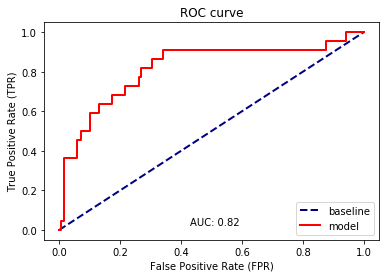

In [7]:
from utils import plot_roc

plot_roc(y_test, pipeline.predict_proba(X_test)[:,1])

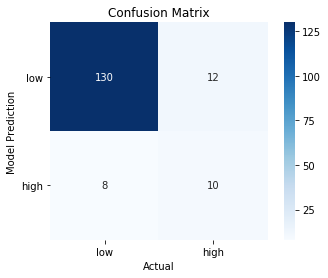

In [8]:
from utils import confusion_matrix_visual

confusion_matrix_visual(y_test, quality_preds, ['low', 'high'])